# A simple example on estimating a spatial temporal Hawkes process in tensorflow.
$\lambda(t_i,X_i) = \mu+\sum_{j:j<i} g(t_i-t_j, X_i-X_j)$,

where $g(t_i-t_j, X_i-X_j) = K_0 w e^{-w(t_i-t_j)}\frac{1}{(2\pi)^{\frac{k}{2}} \|\Sigma\|^{k}} e^{-\frac{1}{2} (X_i-X_j)^T \Sigma^{-1}(X_i-X_j)}$,

$k$ is data dimension.

log-likelihood = $\sum log(\lambda) - \mu*T - K_0*N$, where $T$ is the time span of data and $N$ is size of data.

In [27]:
import math, random
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt
import pylab
import tensorflow as tf



In [28]:
# simulation
def pois(S):
    """
        Generates random numbers from Poisson process
    """
    if S<=100:
        L = math.exp(-S)
        k = 0
        p = 1
        while p > L:
            k += 1
            p *= np.random.random()
        p = k-1
    else:
        p = math.floor(S+math.sqrt(S)*np.random.normal(0,1))
    return p

def Hawkes_Simulation(dim, T, *params):
    """
        Simulates Hawkes point processe with given parameters, 
        with dimension dim
    """
    
    params = list(params)
    mu = params[0]
    K0 = params[1]
    w = params[2]
    sigma = params[3]
    
    times = np.zeros((5000,1))
    x = np.zeros((5000,dim))
    p = pois(mu*T)
    print(p)
    icats = np.zeros((T,1))
    times[:p,0] = np.random.rand(p)*T
    x[:p,:] = np.random.rand(p,dim)*5
#     for i in range(p):
#         times[i,0] = np.random.random()*T
#         x[i,:] = np.random.rand(dim)#0.1*np.random.uniform(0,1,dim) + np.random.randint(0,2,dim)
    counts = 0
    countf = p-1
    
    for j in range(p):
        icats[j] = j+1
    while (countf-counts > -1):
        p0 = pois(K0)
        for j in range(p0):
            temp1 = times[counts]- np.log(np.random.random())/w
            temp2 = x[counts,:] + sigma*np.random.normal(0,1,dim).T

            if temp1 <T:
                countf += 1
                times[countf] = temp1
                x[countf,:] = temp2
                icats[countf] = icats[counts]
        counts += 1
    data = np.concatenate((times[0:countf], x[0:countf,:], icats[0:countf]), axis = 1)
    return data[data[:,0].argsort()]





In [31]:
Data = Hawkes_Simulation(5, 5000, 0.03, 0.9, 1, 0.1)
# Data[:,1] = (Data[:,1] - Data[:,1].min()) / (Data[:,1].max() - Data[:,1].min())
# Data[:,2] = (Data[:,2] - Data[:,2].min()) / (Data[:,2].max() - Data[:,2].min())
# Data[:,3] = (Data[:,3] - Data[:,3].min()) / (Data[:,3].max() - Data[:,3].min())
# Data[:,4] = (Data[:,4] - Data[:,4].min()) / (Data[:,4].max() - Data[:,4].min())
Data.shape

156


(1277, 7)

In [32]:
import matplotlib as mpl
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)



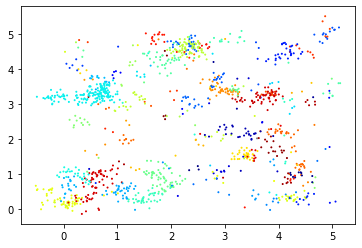

In [34]:
from mpl_toolkits.mplot3d import Axes3D
# time vs 2 dim in space
fig = plt.figure()
plt.scatter(Data[:,2], Data[:,1], s = 1, c = Data[:,6], cmap = cmap)
plt.show()

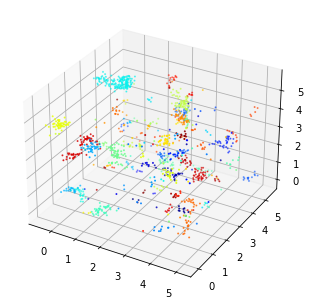

In [35]:
from mpl_toolkits.mplot3d import Axes3D
# time vs 2 dim in space
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Data[:,2], Data[:,1], Data[:,3], s = 1, c = Data[:,6], cmap = cmap)
plt.show()

In [36]:
def pre_process(data, window):
    
    N = data.shape[0]
    row_indices = tf.repeat(0,window)
    full_indices = []
    for i in range(window,N):
        indices = tf.constant(tf.range(i-window,i))
        full_indices.append(indices)
    full_indices = tf.concat(full_indices,axis =0)
    full_indices = tf.reshape(full_indices, (N-window,window))
    S = tf.gather(data, full_indices, 1)
    return S


In [37]:
def dist(A): 
    expanded_a = tf.expand_dims(A, 1)
    expanded_b = tf.expand_dims(A, 0)
#     distances = tf.math.maximum(expanded_a-expanded_b,0)
    return expanded_a-expanded_b

In [38]:
# intensities
class HawkesModel:
    def intensity(self,t_label,x_label):
        const = pow(2*np.pi, self.ndim/2)* pow(self.sigma, self.ndim)
        t = t_label[self.window:,None] - pre_process(t_label, self.window)
        x = x_label[self.window:,None] - pre_process(x_label, self.window)

        return self.mu + tf.reduce_sum(self.K0*self.w*tf.exp(-self.w * t-tf.reduce_sum(x**2,axis = 2)/(2*self.sigma**2))/const, axis = 1)

    def prob_matrix(self, t_label, x_label):
        const = pow(2*np.pi, self.ndim/2)* pow(self.sigma, self.ndim)
        t = t_label[self.window:,None] - pre_process(t_label, self.window)
        x = x_label[self.window:,None] - pre_process(x_label, self.window)
        N = t.shape[0]

        p_inter = self.K0*self.w*tf.exp(-self.w * t-(tf.reduce_sum(x**2,axis = 2))/(2*self.sigma**2))/const
        p_self = tf.reshape(tf.repeat(self.mu, repeats = N), (-1,1))
        p = tf.concat([p_inter,tf.cast(p_self,dtype = tf.float64)],axis = 1)
        r_sum = tf.reduce_sum(p,axis =1)
        p = p / tf.reshape(r_sum,(-1,1))
        return p
    

    def __init__(self, ndim):
        self.window = 100
        self.ndim = ndim
        self.mu = tf.Variable(.1, dtype = tf.float64)
        self.K0 = tf.Variable(.1, dtype = tf.float64)
        self.w = tf.Variable(.1, dtype = tf.float64)
        self.sigma = tf.Variable(.01, dtype = tf.float64)


In [39]:
def log_like(pred, mu, K0):
    T = np.max(Data)
    window = 100
    N = Data.shape[0]-window
    return tf.reduce_sum(tf.math.log(pred)) - mu*T - K0*N


def train_Hawkes(hawkes_model, t, x, lr, flag):    
    with tf.GradientTape() as t2:
        current_loss = log_like(hawkes_model.intensity(t,x), 
                                hawkes_model.mu, hawkes_model.K0)
    mu_grad, K0_grad, w_grad, sig_grad = t2.gradient(current_loss, 
                                                     [hawkes_model.mu, 
                                                      hawkes_model.K0, 
                                                      hawkes_model.w, 
                                                      hawkes_model.sigma])
  
    hawkes_model.mu.assign_sub(-lr * mu_grad)
    hawkes_model.K0.assign_sub(-lr * K0_grad)
    hawkes_model.w.assign_sub(-lr * w_grad)
    hawkes_model.sigma.assign_sub(-lr * sig_grad)
    if flag:
        print(K0_grad.numpy(), w_grad.numpy())


In [40]:
t_label_high = tf.Variable(tf.convert_to_tensor(Data[:,0]), name = 't_high')
s_label_high = tf.Variable(tf.convert_to_tensor(Data[:,1:-1]), name = 'v_high')

In [41]:
s_label_high.shape

TensorShape([1277, 5])

In [43]:
try:
    hawkes_model_high
except NameError:
    pass
else: 
    del hawkes_model_high

hawkes_model_high = HawkesModel(ndim = 5)
epochs_EM = 1000

for epoch_count in range(epochs_EM):
    flag = epoch_count %100 == 0
    train_Hawkes(hawkes_model_high, t_label_high,s_label_high,1e-6, flag)    


    if flag:
        ll = log_like(hawkes_model_high.intensity(t_label_high,s_label_high), hawkes_model_high.mu, hawkes_model_high.K0)
        print(f"Epoch count {epoch_count}: Log likelihood: {ll.numpy()}")

        print(f"mu: {hawkes_model_high.mu.numpy()} K0: {hawkes_model_high.K0.numpy()}")
        print(f"w: {hawkes_model_high.w.numpy()}  sigma: {hawkes_model_high.sigma.numpy()}")

    
p = hawkes_model_high.prob_matrix(t_label_high,s_label_high)



-1131.4268383891306 43.54878566627869
Epoch count 0: Log likelihood: -3092.9345695057877
mu: 0.10673214731555936 K0: 0.09886857316161088
w: 0.10004354878566628  sigma: 0.018827054184951637
1525.642400455787 1501.0992741255568
Epoch count 100: Log likelihood: 1894.2767014004344
mu: 0.029598266877609407 K0: 0.3824602456441826
w: 0.37677312198913826  sigma: 0.09832256754400907
899.7511828012894 916.0440212457129
Epoch count 200: Log likelihood: 2166.0203866366173
mu: 0.02899876605970097 K0: 0.49797632477117204
w: 0.4921945140514702  sigma: 0.09854658076429934
628.8070014252387 664.6291099859495
Epoch count 300: Log likelihood: 2283.1505408074236
mu: 0.028792120954169605 K0: 0.5728353648042926
w: 0.5697688167925299  sigma: 0.09866778200940933
472.4676398288061 519.3085930810701
Epoch count 400: Log likelihood: 2347.3115598911318
mu: 0.028689758897728446 K0: 0.6272144541011084
w: 0.6283355040780408  sigma: 0.09875514924064616
369.6754562607812 423.02597848227515
Epoch count 500: Log likelih

In [16]:
hawkes_model_high.__dict__ # 0.03, 0.9, 1, 0.1

{'window': 100,
 'ndim': 20,
 'mu': <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.0663557743611791>,
 'K0': <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.22999999971639215>,
 'w': <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.09999999981545558>,
 'sigma': <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.009999704442980635>}